In [146]:
%pylab inline
import numpy 
import scipy
import itertools
from umap import UMAP
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from collections import defaultdict as dd

numpy.random.seed(0)

Populating the interactive namespace from numpy and matplotlib


In [67]:
experiments = numpy.loadtxt("/users/kofiamoah/data/search_ui/data/ENCODE_Tracks.txt", dtype=str, delimiter="\t")
celltypes = numpy.unique(experiments[:,0])
assays = numpy.unique(experiments[:,1])

experiments = numpy.array([(celltype, assay) for celltype, assay in itertools.product(celltypes, assays)])

raw_corr = numpy.load('/users/kofiamoah/data/search_ui/data/correlations_33600_600000.npz', )['arr_0']

In [3]:
expt_embedding = scipy.sparse.load_npz('/users/kofiamoah/data/search_ui/encode-ui-sandbox/data/embeddings/experiments_15nn.npz').toarray()

In [4]:
print(celltypes.shape)
print(assays.shape)
print(experiments.shape)
print(expt_embedding.shape)

print (experiments[:10,])
print (assays[:10,])
print (celltypes[:10,])
print (expt_embedding[:3,])

(400,)
(84,)
(33600, 2)
(33600, 33600)
[['J000' 'ATAC-seq_signal_p-value']
 ['J000' 'CAGE_minus_strand_signal_of_all_reads']
 ['J000' 'CAGE_plus_strand_signal_of_all_reads']
 ['J000' 'ChIP-seq_ATF3_signal_p-value']
 ['J000' 'ChIP-seq_BHLHE40_signal_p-value']
 ['J000' 'ChIP-seq_CEBPB_signal_p-value']
 ['J000' 'ChIP-seq_CHD2_signal_p-value']
 ['J000' 'ChIP-seq_CTCF_signal_p-value']
 ['J000' 'ChIP-seq_EGR1_signal_p-value']
 ['J000' 'ChIP-seq_ELF1_signal_p-value']]
['ATAC-seq_signal_p-value' 'CAGE_minus_strand_signal_of_all_reads'
 'CAGE_plus_strand_signal_of_all_reads' 'ChIP-seq_ATF3_signal_p-value'
 'ChIP-seq_BHLHE40_signal_p-value' 'ChIP-seq_CEBPB_signal_p-value'
 'ChIP-seq_CHD2_signal_p-value' 'ChIP-seq_CTCF_signal_p-value'
 'ChIP-seq_EGR1_signal_p-value' 'ChIP-seq_ELF1_signal_p-value']
['J000' 'J002' 'J004' 'J006' 'J007' 'J008' 'J010' 'J011' 'J012' 'J013']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [5]:
rna_mask = numpy.array(['RNA' in assay or 'CAGE' in assay or 'RAMPAGE' in assay for assay in experiments[:,1]], dtype=bool)
tf_mask = numpy.array(['ChIP' in assay and assay[9]+assay[11] != 'HK' for assay in experiments[:,1]], dtype=bool)
his_mask = numpy.array(['ChIP' in assay and assay[9]+assay[11] == 'HK' for assay in experiments[:,1]], dtype=bool)
acc_mask = numpy.array(['ATAC' in assay or 'DNase' in assay for assay in experiments[:,1]], dtype=bool)

In [135]:
#Fit kNN model with k=15
#knn = NearestNeighbors(n_neighbors=15)
#knn.fit(expt_embedding2)
#all_nn = knn.kneighbors(return_distance=False)

#print(all_nn.shape)

In [147]:
#X_umap = UMAP(200, random_state=111).fit_transform(expt_embedding)
#Load pre-computed umap coordinates
#X_umap = numpy.loadtxt('/users/kofiamoah/data/search_ui/encode-ui-sandbox/data/embeddings/experiments_15nn_umap_coord.txt')

#Load cell-type mapping
cell_type_map = dd(str)
with open('/users/kofiamoah/data/search_ui/encode-ui-sandbox/data/Biosample Names.txt') as f:
    for line in f:
        cell_id, full_name = line.strip('\n').split('\t')[0], line.strip('\n').split('\t')[1]
        cell_type_map[cell_id] = full_name
        
print(cell_type_map['J000'])

KMS-11


In [157]:
def get_neigbors(query_expt_index, embeddings, experiments):
    neighbors = experiments[numpy.where(embeddings[query_expt_index,:] != 0)]
    print("Query: {} in {}".format(experiments[query_expt_index][1], cell_type_map[experiments[query_expt_index][0]]))
    print("Neighbors: (Cell-type ==> Assay)")
    for n in neighbors:
        print('{} ==> {}'.format(cell_type_map[n[0]], n[1]))
    #Summarize
    print("===========SUMMARY=============")
    print("Neighbor Assay\t\t\tNeighbor Count")
    uniq_assays = numpy.unique(neighbors[:,1], return_counts=True)
    for i in range(len(uniq_assays[0])):
        print('{}\t\t{}'.format(uniq_assays[0][i], uniq_assays[1][i]))
    return neighbors

In [152]:
def get_neighbor_mask(experiment, neighbor):
    return experiment[0] == neighbor[0] and experiment[1] == neighbor[1]

In [153]:
def plot_query_neighbors(query_expt_index, neighbors, experiments):
    neighbor_mask = numpy.squeeze([numpy.where(numpy.apply_along_axis(get_neighbor_mask, 1, experiments, neighbors[i])) for i in range(neighbors.shape[0])])

    plt.figure(figsize=(20, 20), facecolor='w')
    plt.scatter(*X_umap.T, s=0.1, color='0.7')
    plt.scatter(*X_umap[neighbor_mask].T, s=40, label="Neighbors", color='r', alpha=0.5) #Neighbors
    plt.scatter(*X_umap[query_expt_index].T, s=40, label="Query", color='b', alpha=0.5) #Query
    
    plt.title("{} in {}".format(experiments[query_expt_index][1], cell_type_map[experiments[query_expt_index][0]]), fontsize=14)
    plt.axis('off')

    plt.legend(fontsize=14, loc=(1.01, 0.3), markerscale=5)
    plt.show()

Query: ChIP-seq_H3K9me2_signal_p-value in SK-N-SH
Neighbors: (Cell-type ==> Assay)
HEK293T ==> ChIP-seq_H3K9me2_signal_p-value
hepatocyte originated from H9 ==> ChIP-seq_H3K9me2_signal_p-value
Peyer's patch male adult (54 years) ==> ChIP-seq_H3K9me2_signal_p-value
SK-N-SH nuclear fraction ==> ChIP-seq_H3K9me2_signal_p-value
SK-N-SH cytosolic fraction ==> ChIP-seq_H3K9me2_signal_p-value
omental fat pad male adult (37 years) ==> ChIP-seq_H3K9me2_signal_p-value
adrenal gland male adult (54 years) ==> ChIP-seq_H3K9me2_signal_p-value
adrenal gland male adult (54 years) ==> ChIP-seq_H3K9me3_signal_p-value
GM23248 ==> ChIP-seq_H3K9me2_signal_p-value
thyroid gland male adult (54 years) ==> ChIP-seq_H3K9me2_signal_p-value
thyroid gland male adult (54 years) ==> ChIP-seq_H3K9me3_signal_p-value
liver female child (4 years) ==> ChIP-seq_H3K9me2_signal_p-value
lung female embryo (20 weeks) and female embryo (24 weeks) ==> ChIP-seq_H3K9me2_signal_p-value
uterus female embryo (24 weeks) and female em

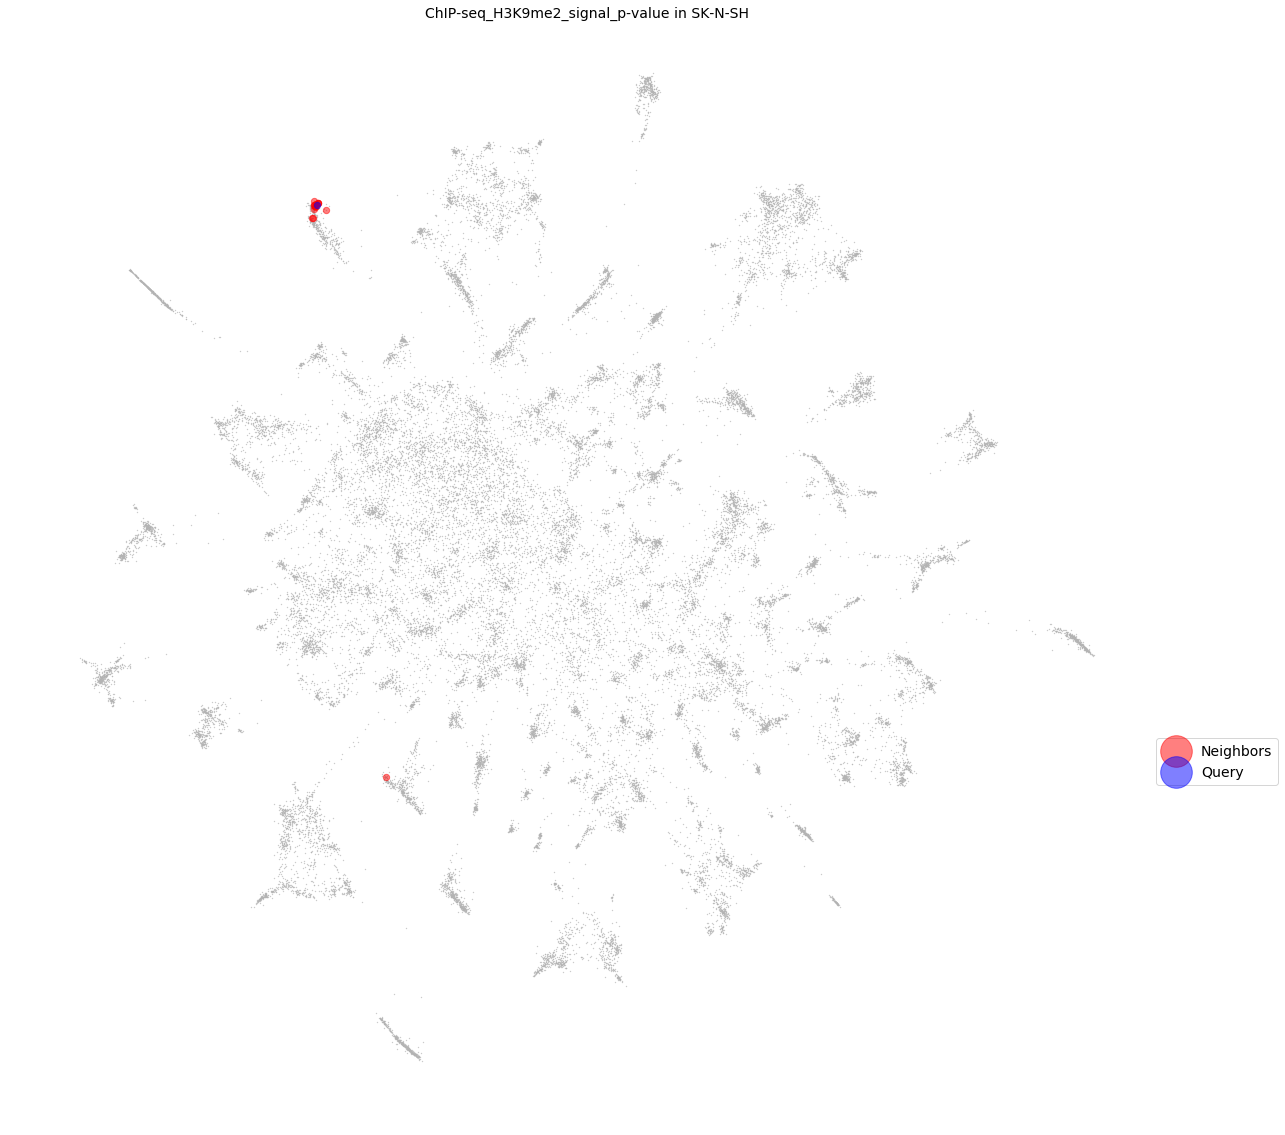

Query: ChIP-seq_YY1_signal_p-value in K562
Neighbors: (Cell-type ==> Assay)
K562 ==> ChIP-seq_CHD2_signal_p-value
K562 ==> ChIP-seq_ELF1_signal_p-value
K562 ==> ChIP-seq_MAX_signal_p-value
K562 ==> ChIP-seq_MAZ_signal_p-value
K562 ==> DNase-seq_read-depth_normalized_signal
A549 cytosolic fraction ==> ChIP-seq_YY1_signal_p-value
A549 nuclear fraction ==> ChIP-seq_YY1_signal_p-value
A375 ==> ChIP-seq_YY1_signal_p-value
K562 cytosolic fraction ==> ChIP-seq_MAX_signal_p-value
K562 cytosolic fraction ==> ChIP-seq_YY1_signal_p-value
K562 nucleolus fraction ==> ChIP-seq_MAX_signal_p-value
K562 nucleolus fraction ==> ChIP-seq_YY1_signal_p-value
K562 nuclear fraction ==> ChIP-seq_MAX_signal_p-value
K562 nuclear fraction ==> ChIP-seq_YY1_signal_p-value
adrenal gland male embryo (97 days) ==> ChIP-seq_YY1_signal_p-value
===========SUMMARY=============
Neighbor Assay			Neighbor Count
ChIP-seq_CHD2_signal_p-value		1
ChIP-seq_ELF1_signal_p-value		1
ChIP-seq_MAX_signal_p-value		4
ChIP-seq_MAZ_signal_

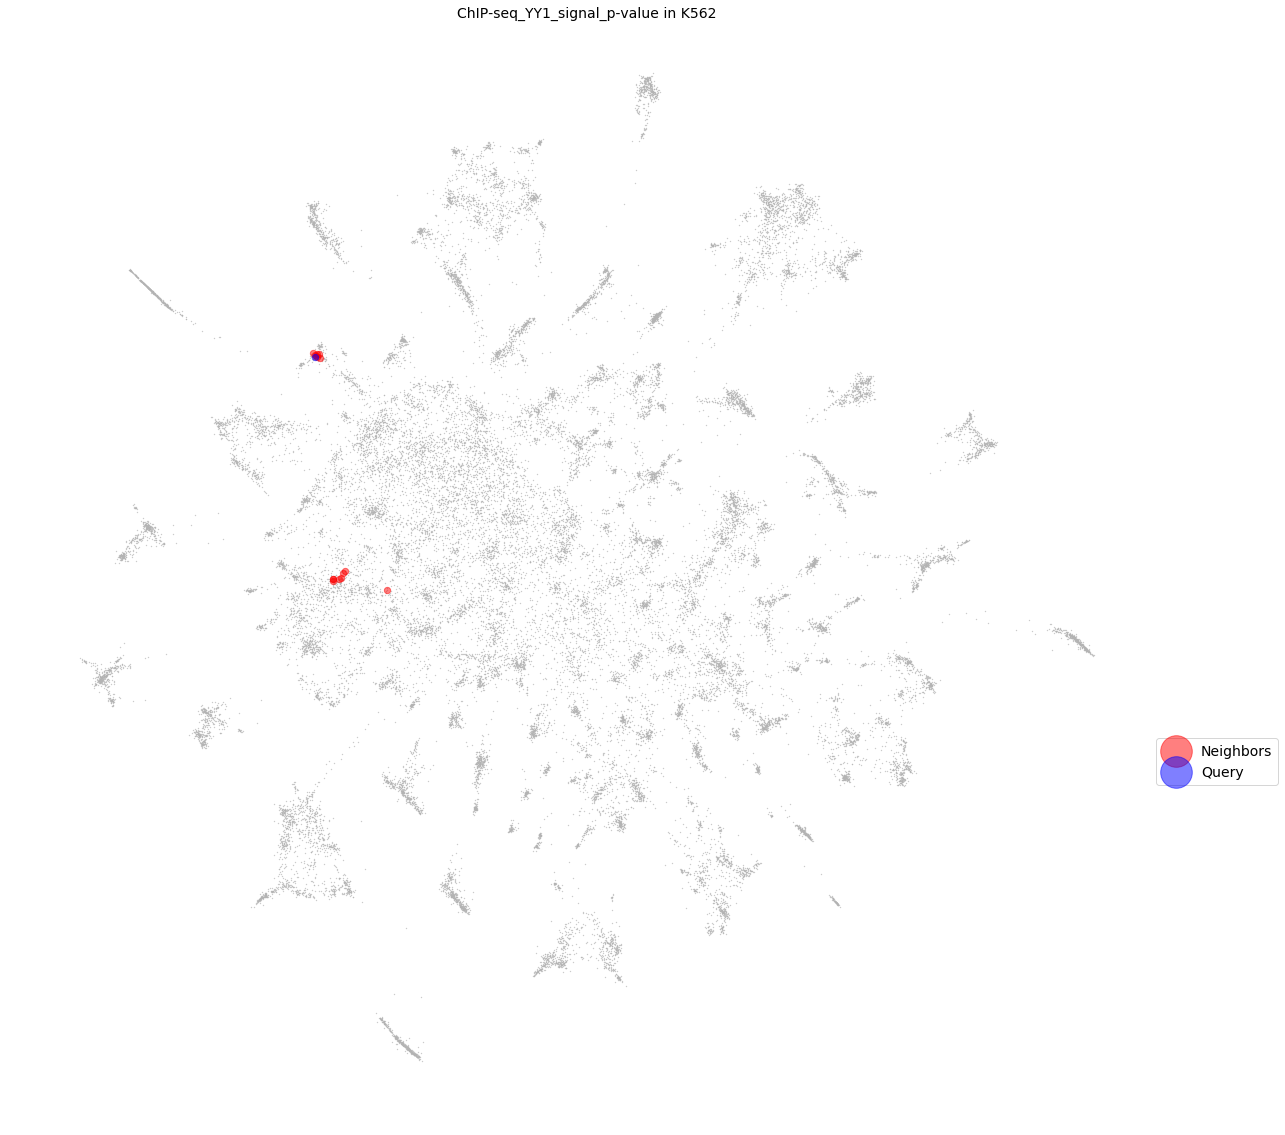

Query: ChIP-seq_SUZ12_signal_p-value in epithelial cell of proximal tubule
Neighbors: (Cell-type ==> Assay)
fibroblast of lung male adult (45 years) ==> ChIP-seq_SUZ12_signal_p-value
HT1080 nuclear fraction ==> ChIP-seq_SUZ12_signal_p-value
muscle of leg female embryo (110 days) ==> ChIP-seq_SUZ12_signal_p-value
skeletal muscle satellite cell female adult originated from mesodermal cell ==> ChIP-seq_SUZ12_signal_p-value
IMR-90 ==> ChIP-seq_SUZ12_signal_p-value
mesenchymal stem cell originated from adipose tissue ==> ChIP-seq_SUZ12_signal_p-value
skeletal muscle satellite cell female adult (64 years) and male adult (21 year) ==> ChIP-seq_SUZ12_signal_p-value
osteoblast ==> ChIP-seq_SUZ12_signal_p-value
kidney epithelial cell ==> ChIP-seq_SUZ12_signal_p-value
substantia nigra male adult (81 year) ==> ChIP-seq_SUZ12_signal_p-value
NCI-H460 nuclear fraction ==> ChIP-seq_SUZ12_signal_p-value
caudate nucleus male adult (81 year) ==> ChIP-seq_SUZ12_signal_p-value
LHCN-M2 ==> ChIP-seq_SUZ12_si

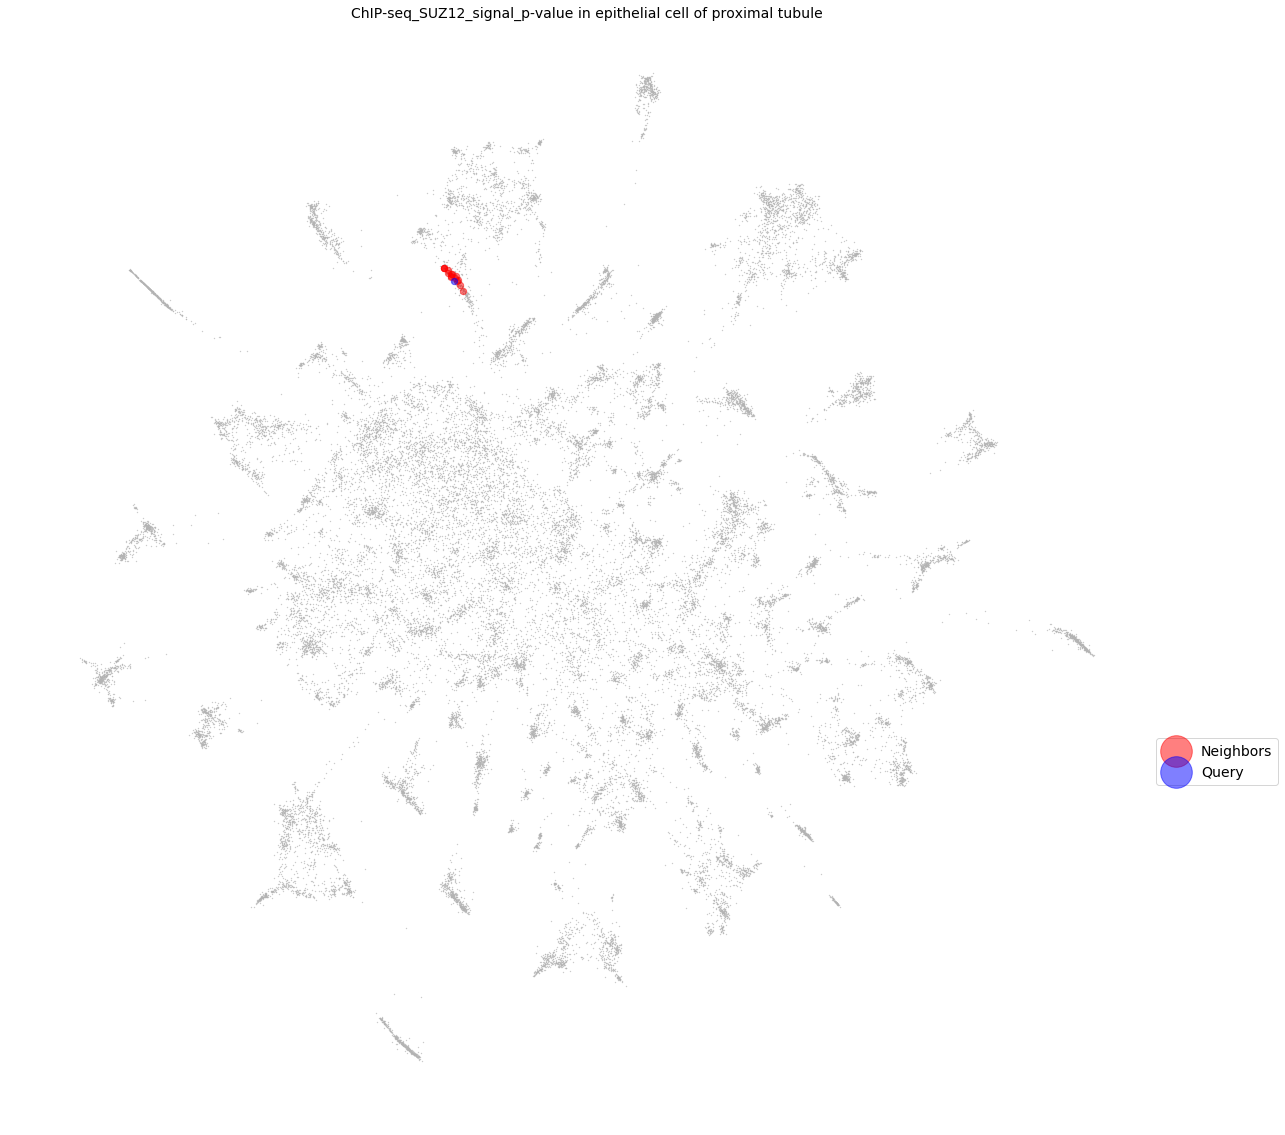

Query: ChIP-seq_MAZ_signal_p-value in kidney female embryo (120 days)
Neighbors: (Cell-type ==> Assay)
IMR-90 nuclear fraction ==> ChIP-seq_CHD2_signal_p-value
IMR-90 nuclear fraction ==> ChIP-seq_MAZ_signal_p-value
mucosa of rectum female adult (50 years) ==> ChIP-seq_MAZ_signal_p-value
HepG2 nuclear fraction ==> ChIP-seq_MAZ_signal_p-value
HeLa-S3 nuclear fraction ==> ChIP-seq_MAZ_signal_p-value
brain male embryo (122 days) ==> ChIP-seq_MAZ_signal_p-value
A375 ==> ChIP-seq_CHD2_signal_p-value
A375 ==> ChIP-seq_MAZ_signal_p-value
lung female embryo (120 days) ==> ChIP-seq_MAZ_signal_p-value
kidney female embryo (120 days) ==> ChIP-seq_CHD2_signal_p-value
kidney female embryo (120 days) ==> ChIP-seq_RCOR1_signal_p-value
kidney female embryo (120 days) ==> ChIP-seq_SIN3A_signal_p-value
small intestine male child (3 years) ==> ChIP-seq_MAZ_signal_p-value
Daoy ==> ChIP-seq_MAZ_signal_p-value
duodenal mucosa male adult (59 years) ==> ChIP-seq_MAZ_signal_p-value
===========SUMMARY==========

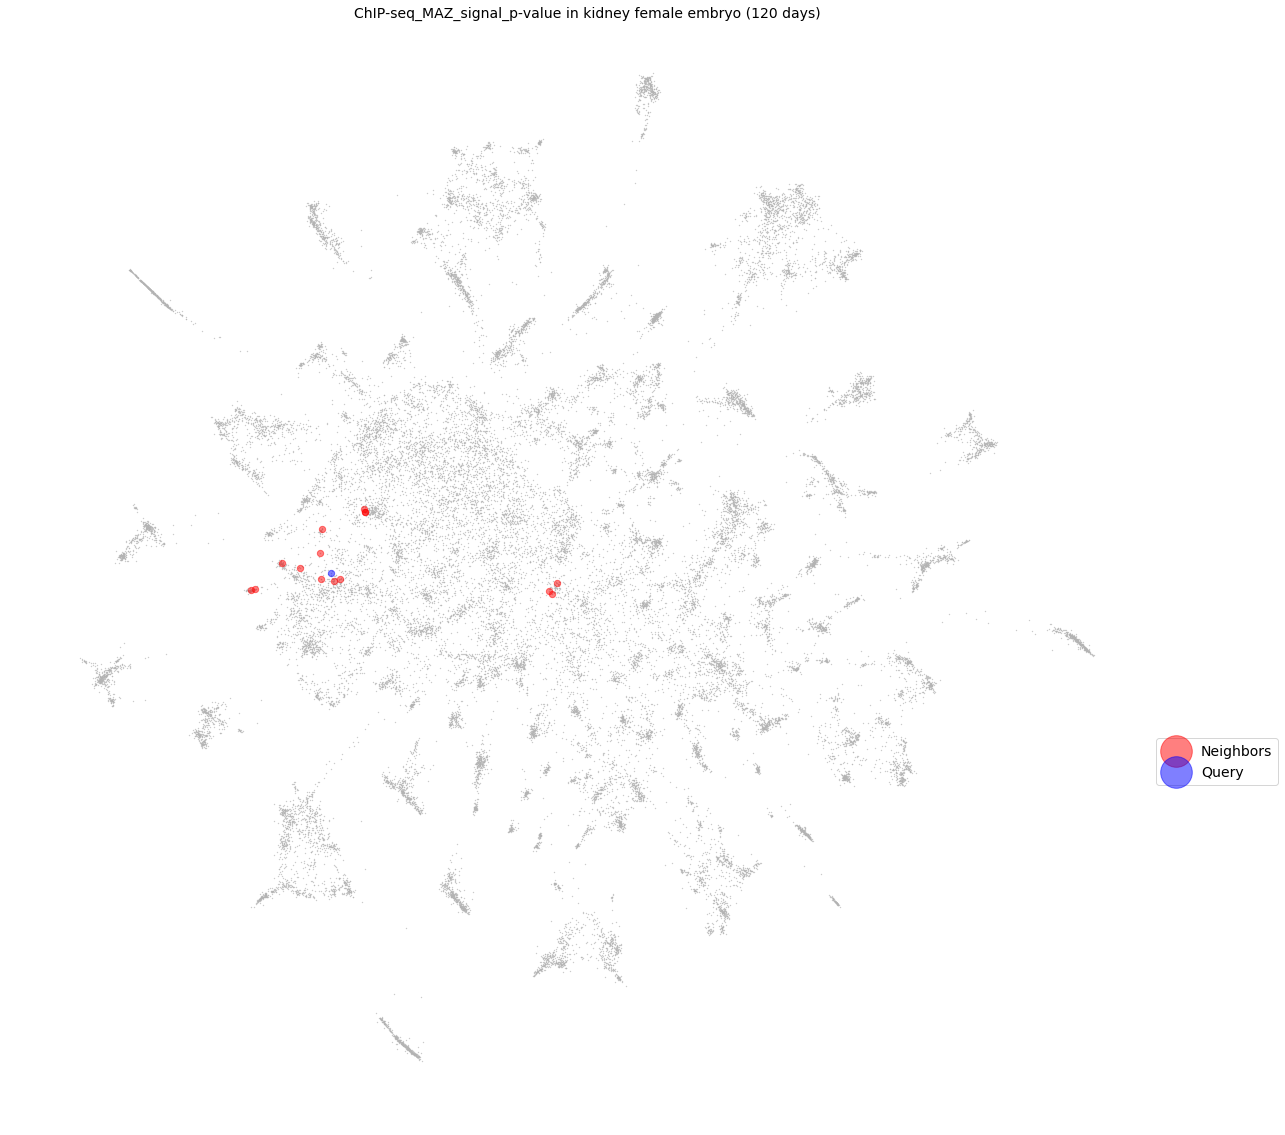

Query: polyA_depleted_RNA-seq_minus_strand_signal_of_all_reads in gastrocnemius medialis male adult (37 years)
Neighbors: (Cell-type ==> Assay)
gastrocnemius medialis female adult (53 years) ==> polyA_depleted_RNA-seq_minus_strand_signal_of_all_reads
gastroesophageal sphincter female adult (51 year) ==> polyA_depleted_RNA-seq_minus_strand_signal_of_all_reads
esophagus muscularis mucosa female adult (51 year) ==> polyA_depleted_RNA-seq_minus_strand_signal_of_all_reads
psoas muscle male adult (34 years) ==> polyA_depleted_RNA-seq_minus_strand_signal_of_all_reads
psoas muscle male child (3 years) ==> polyA_depleted_RNA-seq_minus_strand_signal_of_all_reads
adrenal gland female adult (53 years) ==> polyA_depleted_RNA-seq_minus_strand_signal_of_all_reads
gastrocnemius medialis male adult (54 years) ==> polyA_depleted_RNA-seq_minus_strand_signal_of_all_reads
gastrocnemius medialis female adult (51 year) ==> polyA_depleted_RNA-seq_minus_strand_signal_of_all_reads
skeletal muscle tissue male ad

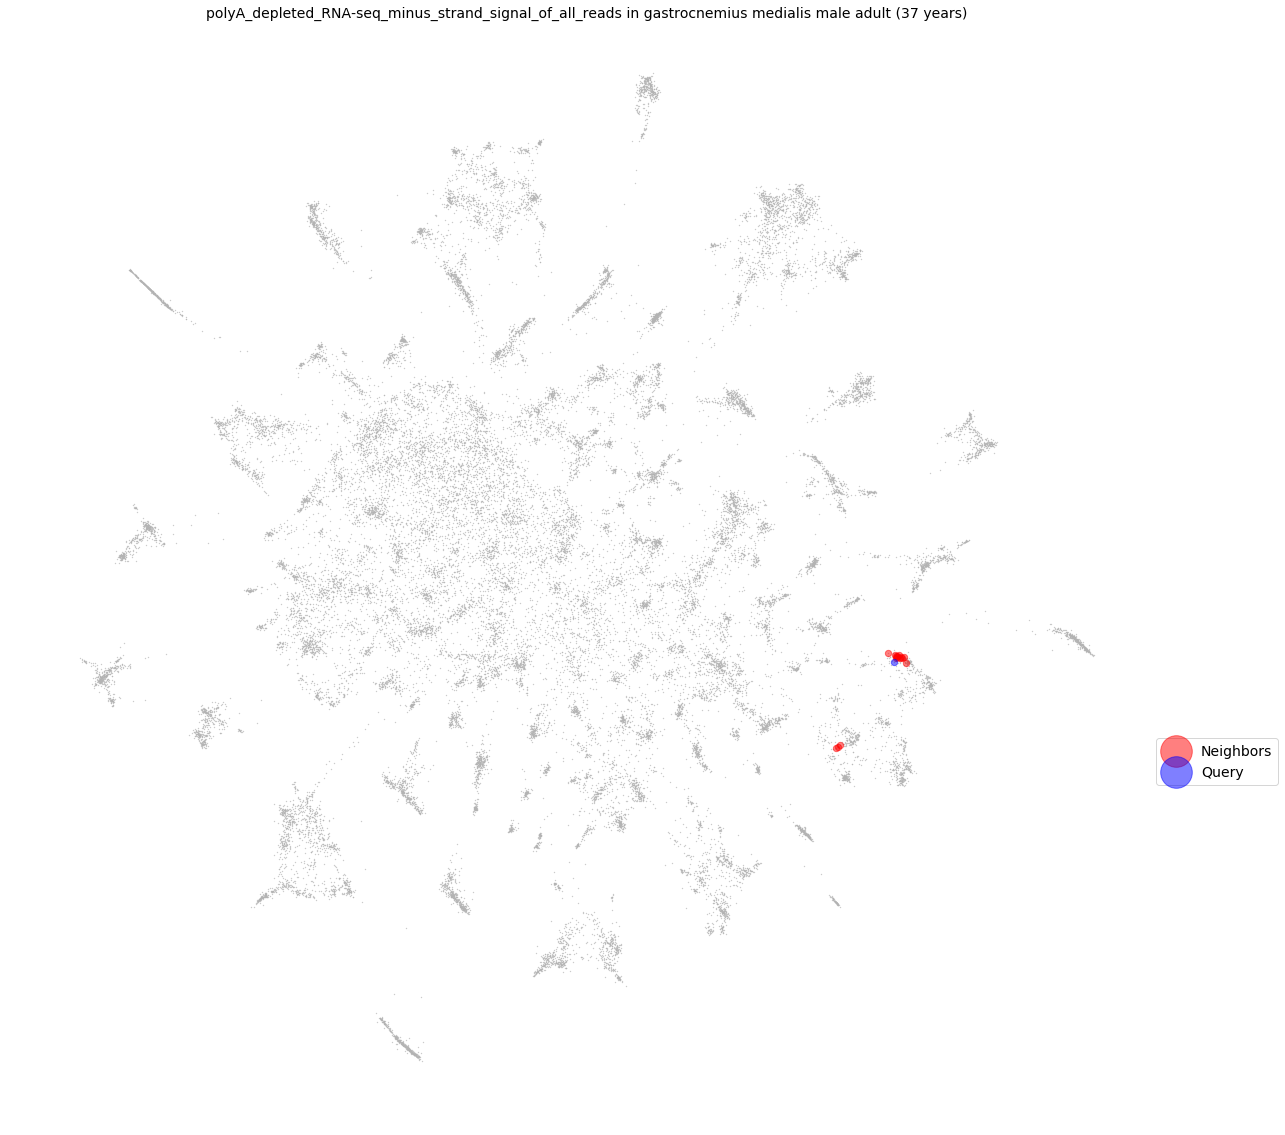

Query: ChIP-seq_RAD21_signal_p-value in omental fat pad male adult (37 years)
Neighbors: (Cell-type ==> Assay)
stomach male adult (37 years) ==> ChIP-seq_RAD21_signal_p-value
HEK293T ==> ChIP-seq_RAD21_signal_p-value
HEK293T ==> ChIP-seq_SMC3_signal_p-value
lower leg skin female adult (53 years) ==> ChIP-seq_CTCF_signal_p-value
lower leg skin female adult (53 years) ==> ChIP-seq_RAD21_signal_p-value
omental fat pad male adult (54 years) ==> ChIP-seq_CTCF_signal_p-value
omental fat pad male adult (54 years) ==> ChIP-seq_RAD21_signal_p-value
omental fat pad male adult (37 years) ==> ChIP-seq_CTCF_signal_p-value
omental fat pad male adult (37 years) ==> ChIP-seq_SMC3_signal_p-value
right atrium auricular region female adult (51 year) ==> ChIP-seq_FOXA1_signal_p-value
transverse colon female adult (51 year) ==> ChIP-seq_RAD21_signal_p-value
lower leg skin female adult (51 year) ==> ChIP-seq_RAD21_signal_p-value
suprapubic skin male adult (54 years) ==> ChIP-seq_RAD21_signal_p-value
omental

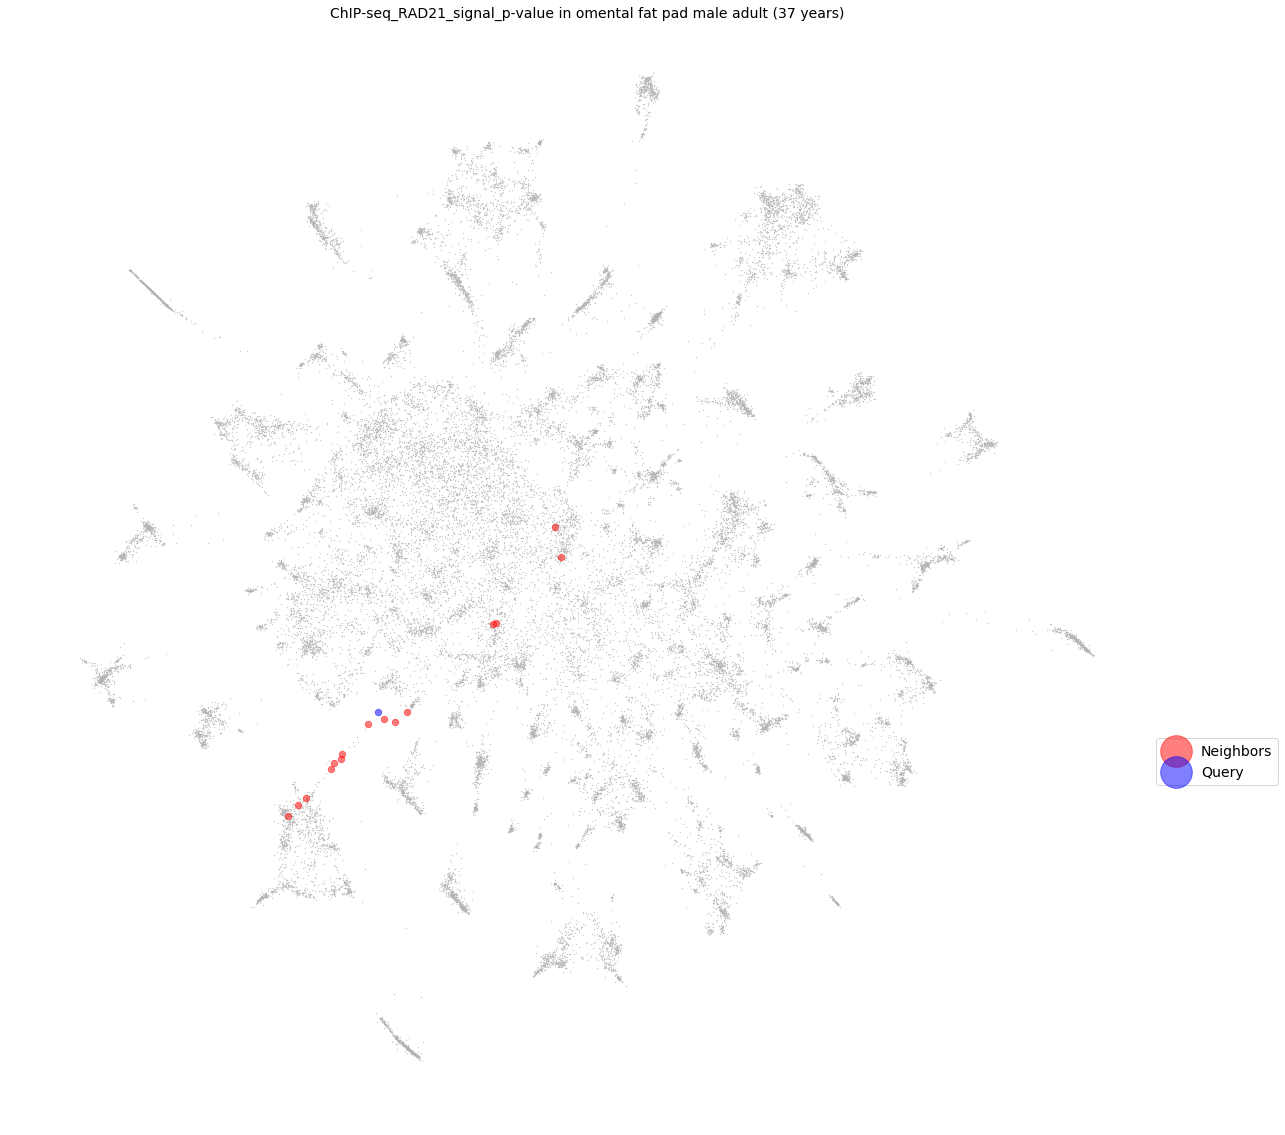

Query: RAMPAGE_minus_strand_signal_of_all_reads in iPS-20b male adult (55 years)
Neighbors: (Cell-type ==> Assay)
sigmoid colon male adult (54 years) ==> RAMPAGE_minus_strand_signal_of_all_reads
neural progenitor cell originated from H9 ==> RAMPAGE_minus_strand_signal_of_all_reads
sigmoid colon male adult (37 years) ==> RAMPAGE_minus_strand_signal_of_all_reads
GM23338 male adult (53 years) originated from GM23248 ==> RAMPAGE_minus_strand_signal_of_all_reads
H1-hESC cytosolic fraction ==> RAMPAGE_minus_strand_signal_of_all_reads
iPS-18a female adult (48 years) ==> RAMPAGE_minus_strand_signal_of_all_reads
HUES48 ==> RAMPAGE_minus_strand_signal_of_all_reads
gastroesophageal sphincter male adult (54 years) ==> RAMPAGE_minus_strand_signal_of_all_reads
frontal cortex female embryo (20 weeks) and male embryo (22 weeks) ==> RAMPAGE_minus_strand_signal_of_all_reads
occipital lobe female embryo (20 weeks) and male embryo (22 weeks) ==> RAMPAGE_minus_strand_signal_of_all_reads
subcutaneous preadi

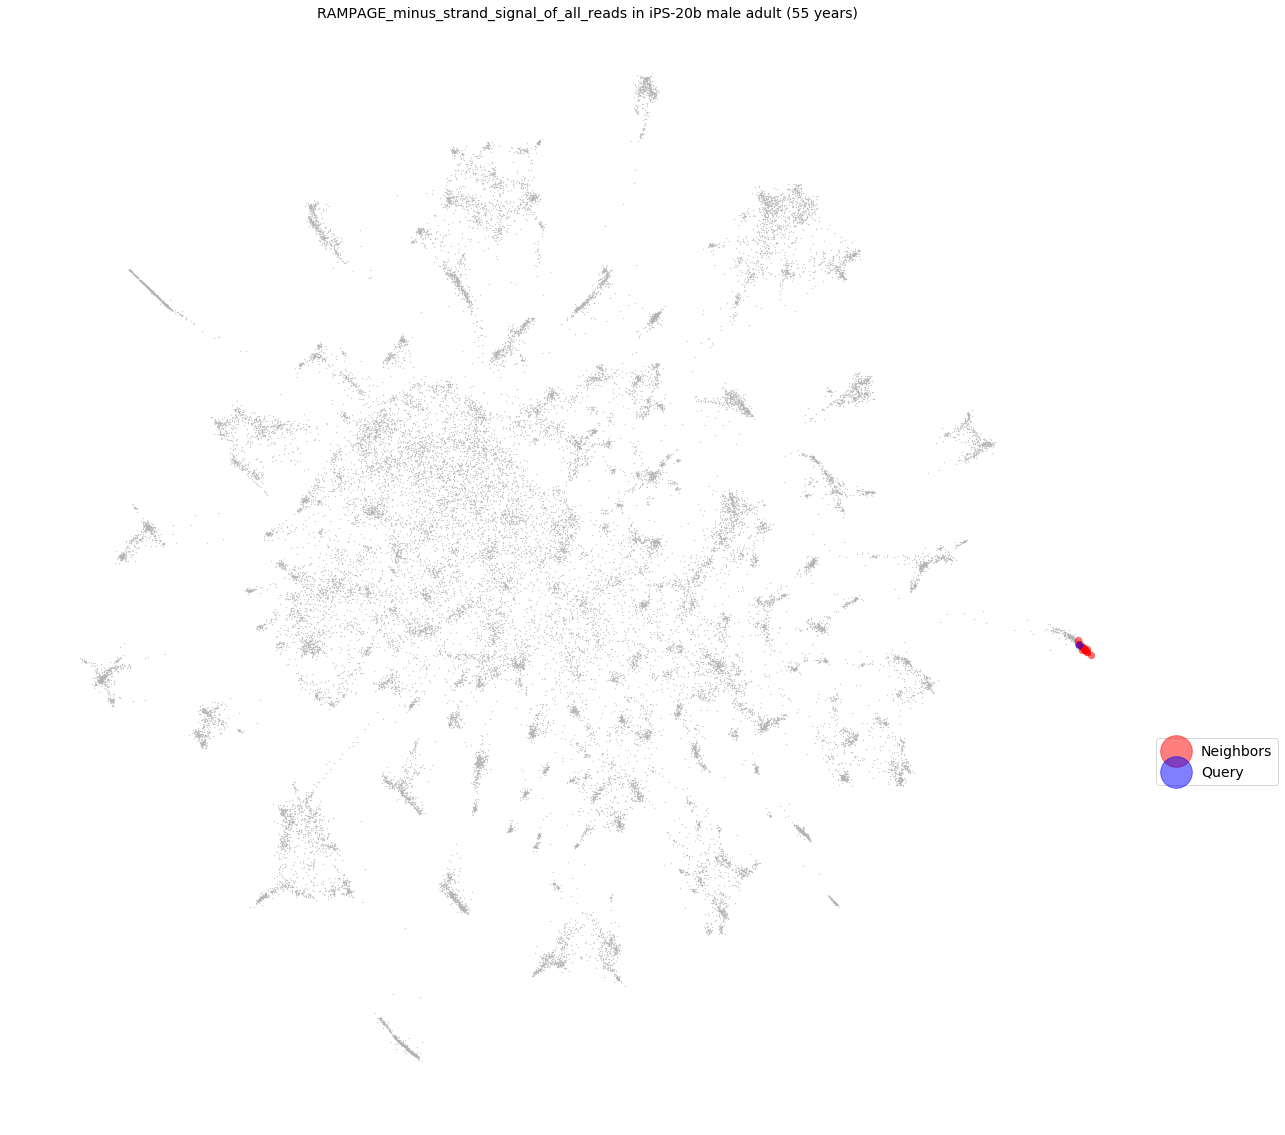

Query: DNase-seq_read-depth_normalized_signal in OCI-LY1
Neighbors: (Cell-type ==> Assay)
GM12878 ==> DNase-seq_read-depth_normalized_signal
GM12878 cytosolic fraction ==> DNase-seq_read-depth_normalized_signal
thymus female embryo (110 days) ==> DNase-seq_read-depth_normalized_signal
peripheral blood mononuclear cell male adult (39 years) ==> DNase-seq_read-depth_normalized_signal
HeLa-S3 nuclear fraction ==> DNase-seq_read-depth_normalized_signal
melanocyte of skin male child (1 year) and male child (3 years) ==> DNase-seq_read-depth_normalized_signal
GM12878 nuclear fraction ==> DNase-seq_read-depth_normalized_signal
CD8-positive, alpha-beta memory T cell ==> DNase-seq_read-depth_normalized_signal
melanocyte of skin female adult (52 years) and male adult (55 years) ==> DNase-seq_read-depth_normalized_signal
DOHH2 ==> DNase-seq_read-depth_normalized_signal
DND-41 ==> DNase-seq_read-depth_normalized_signal
GM12878 nucleolus fraction ==> DNase-seq_read-depth_normalized_signal
K562 nucl

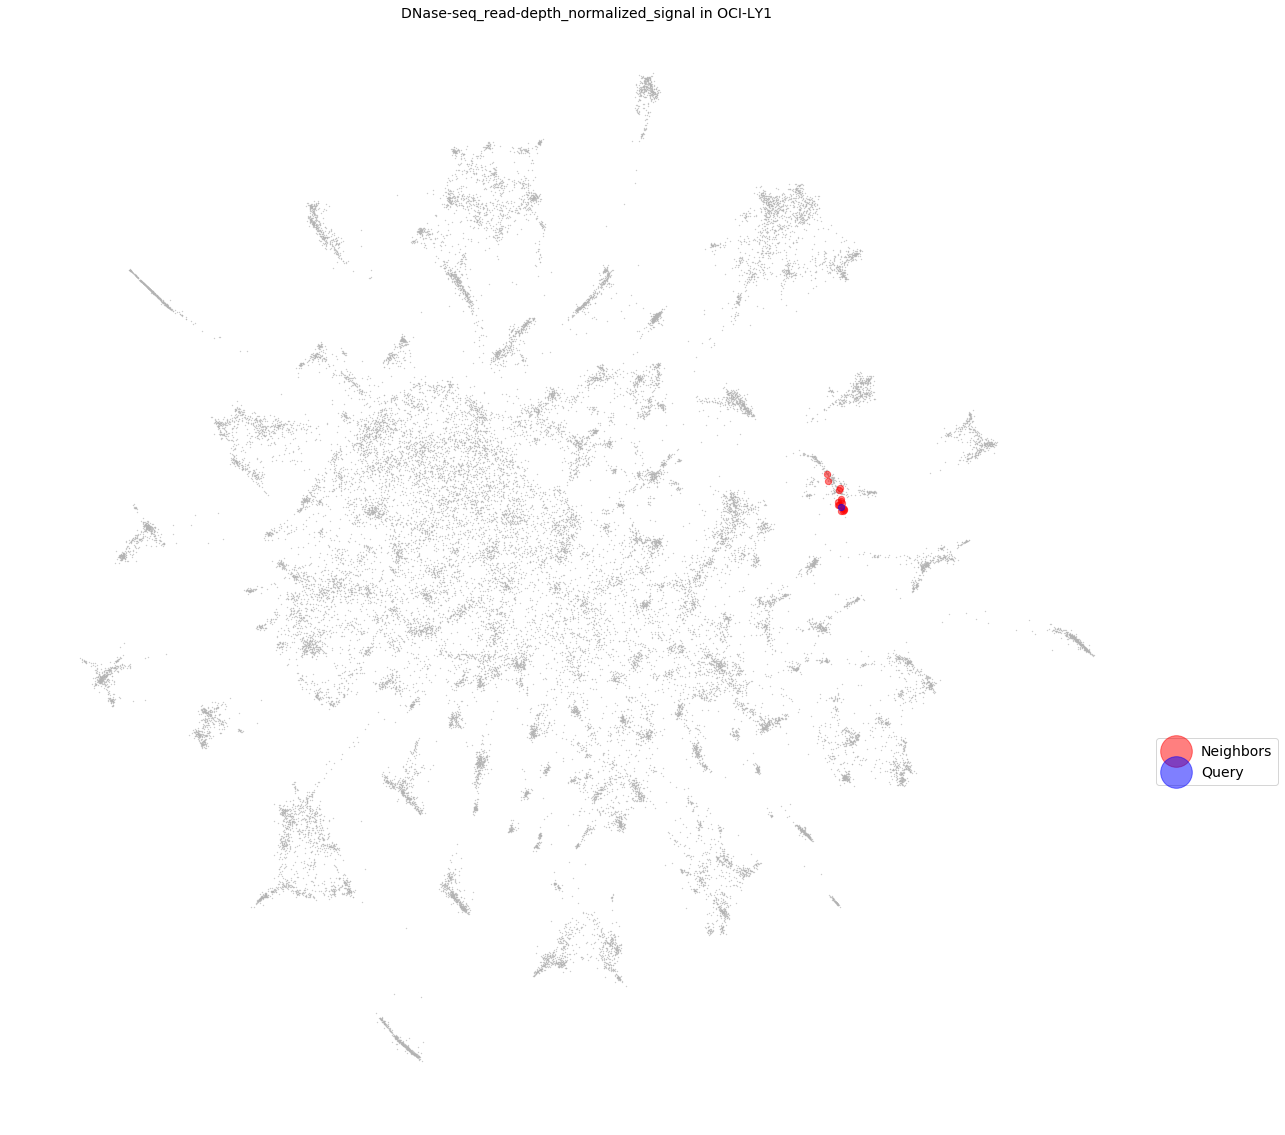

In [158]:
# Test functions above
ex_cases = [123, 236, 901, 21973, 5454, 17777, 33000, 6791] #example cases
#Histone: 123 vs 6999
#TF : 236 or 21973 vs 490
#RNA: 5454
#ATAC-Seq: 16632, 6791

for query_idx in ex_cases:
    neighbors = get_neigbors(query_idx, expt_embedding, experiments)
    #print('Neighbor Correlations: {}'.format(raw_corr[236, expt_embedding[236] != 0]))
    plot_query_neighbors(query_idx, neighbors, experiments)